In [38]:
from util_input_output_model import *
from collections import defaultdict
from datetime import timedelta
import tensorflow as tf
import numpy as np
import pandas as pd

provinces = ['Bangkok','Chanthaburi','Chiang Mai','Kanchanaburi','Songkhla','Khon Kaen']
tf.__version__

'2.5.0-rc1'

## Preparing data
We'll preparing `X, Y` of `Train, Test` set.

In [39]:
print("Enter timestep : ",end=' ')
timesteps = int(input())
print(timesteps)

Enter timestep :  24


In [42]:
Train_data, X_train, Y_train = prepare_train_data(timesteps)

In [43]:
Test_data, X_test, Y_test = prepare_test_data(Train_data, timesteps)

dif : 19
2019-03-18 08:00:00
base = 2019-03-18 12:00:00
dif : 13
2019-03-18 08:00:00
base = 2019-03-18 18:00:00
dif : 7
2019-03-18 08:00:00
base = 2019-03-19 00:00:00
dif : 1
2019-03-18 08:00:00
base = 2019-03-19 06:00:00


## Standardize the data
Next, we need to scale the data.

In [44]:
x_train_scalers, y_train_scalers, X_train_scaled, Y_train_scaled = scale_data(X_train, Y_train, Train_data)
x_test_scalers, y_test_scalers, X_test_scaled, Y_test_scaled = scale_data(X_test, Y_test, Test_data)

## Shaping
Make sure that the data is in the right shape. The `X` shape should be `(#datapoints, #timesteps, #features)`. The `Y` shape should be `(#datapoints, 72)` since each forecast we have to predict next 72 hours.

In [45]:
f = Y_train_scaled['Bangkok']

for i in range(len(f)):
    if f[i].shape[0] != 72: print(i)

In [46]:
x_, y_ = {}, {}

for p in provinces:
    x_[p] = {"Train": np.array(X_train_scaled[p]),
             "Test": np.array(X_test_scaled[p])}
    
    y_[p] = {"Train": np.array(Y_train_scaled[p]).squeeze(axis=2),
             "Test": np.array(Y_test_scaled[p]).squeeze(axis=2)}

    print(p)
    print(f'X Train: {x_[p]["Train"].shape}')
    print(f'Y Train: {y_[p]["Train"].shape}')
    print(f'X Test: {x_[p]["Test"].shape}')
    print(f'Y Test: {y_[p]["Test"].shape}\n')

Bangkok
X Train: (4422, 24, 7)
Y Train: (4422, 72)
X Test: (1454, 24, 7)
Y Test: (1454, 72)

Chanthaburi
X Train: (4422, 24, 7)
Y Train: (4422, 72)
X Test: (1454, 24, 7)
Y Test: (1454, 72)

Chiang Mai
X Train: (4422, 24, 7)
Y Train: (4422, 72)
X Test: (1454, 24, 7)
Y Test: (1454, 72)

Kanchanaburi
X Train: (4422, 24, 7)
Y Train: (4422, 72)
X Test: (1454, 24, 7)
Y Test: (1454, 72)

Songkhla
X Train: (4422, 24, 7)
Y Train: (4422, 72)
X Test: (1454, 24, 7)
Y Test: (1454, 72)



In [27]:
'''
x_train = x_.reshape((x_.shape[0], timesteps, n_features))
y_train = y_.reshape((y_.shape[0], 72))
'''

In [28]:
'''
print(f'x : {x_train.shape}')
print(f'y : {y_train.shape}')
'''

x : (1452, 12, 7)
y : (1452, 72)


## Building Model

In [47]:
print(f"timesteps : {timesteps}")

timesteps : 24


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf

n_features = 7
# define model

model = Sequential([
    LSTM(200, activation='relu', input_shape=(timesteps, n_features)),
    Dense(144, activation='relu'),
    Dense(72)
])
model.compile(optimizer='adam', loss='mse')

In [49]:
provinces

['Bangkok', 'Chanthaburi', 'Chiang Mai', 'Kanchanaburi', 'Songkhla']

In [51]:
x_['Songkhla']['Test'].shape

(1454, 24, 7)

In [52]:
province = 'Songkhla'
x_feed, y_feed = x_[province]['Test'], y_[province]['Test']
history = model.fit(x_feed, y_feed, epochs=50, batch_size=32)

Epoch 1/50
46/46 [==============================] - 4s 32ms/step - loss: 0.0232
Epoch 2/50
46/46 [==============================] - 2s 54ms/step - loss: 0.0154
Epoch 3/50
46/46 [==============================] - 2s 50ms/step - loss: 0.0146
Epoch 4/50
46/46 [==============================] - 2s 48ms/step - loss: 0.0162
Epoch 5/50
46/46 [==============================] - 2s 40ms/step - loss: 0.0159
Epoch 6/50
46/46 [==============================] - 2s 42ms/step - loss: 0.0146
Epoch 7/50
46/46 [==============================] - 2s 43ms/step - loss: 0.0159
Epoch 8/50
46/46 [==============================] - 2s 39ms/step - loss: 0.0145
Epoch 9/50
46/46 [==============================] - 2s 40ms/step - loss: 0.0149
Epoch 10/50
46/46 [==============================] - 2s 47ms/step - loss: 0.0143
Epoch 11/50
46/46 [==============================] - 2s 38ms/step - loss: 0.0141
Epoch 12/50
46/46 [==============================] - 2s 39ms/step - loss: 0.0143
Epoch 13/50
46/46 [==================

### Evaluate on train

In [53]:
model.evaluate(x_feed, y_feed)

46/46 [==============================] - 1s 10ms/step - loss: 0.0098


0.009834391996264458

### Evaluate on test

In [ ]:
#model.evaluate(x_test, y_test)

In [54]:
from sklearn.metrics import mean_squared_error as mse
pred = model(x_feed)
rmse = []
print('province :', province)
for i in range(len(pred)):
    p = y_test_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
    y_t = y_test_scalers[province].inverse_transform(y_feed[i].reshape((-1,1)))
    rmse.append(np.sqrt(mse(p, y_t)))
np.mean(rmse)

province : Songkhla


7.405307186991287

province = Songkhla


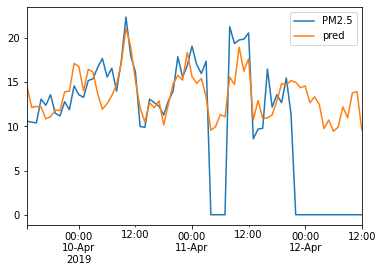

In [55]:
i = 88
print('province =',province)
h = y_test_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
k = Y_test[province][i].copy()
k['pred'] = h
k.plot();

## Save the model
- `Bangkok`

In [28]:
if not os.path.exists("./Models/Bangkok.h5"):
    model.save("./Models/Bangkok.h5")
    print("Bangkok model : saved")
else: print("Bangkok model is ready")

Bangkok model is ready


In [29]:
if not os.path.exists("./Models/Chanthaburi.h5"):
    model.save("./Models/Chanthaburi.h5")
    print("Chanthaburi model : saved")
else: print("Chanthaburi model is ready")

Chanthaburi model : saved


In [43]:
if not os.path.exists("./Models/Chiang Mai.h5"):
    model.save("./Models/Chiang Mai.h5")
    print("Chiang Mai model : saved")
else: print("Chiang Mai model is ready")

Chiang Mai model : saved


In [52]:
if not os.path.exists("./Models/Kanchanaburi.h5"):
    model.save("./Models/Kanchanaburi.h5")
    print("Kanchanaburi model : saved")
else: print("Kanchanaburi model is ready")

Kanchanaburi model : saved


In [60]:
if not os.path.exists("./Models/Songkhla.h5"):
    model.save("./Models/Songkhla.h5")
    print("Songkhla model : saved")
else: print("Songkhla model is ready")

Songkhla model : saved


In [52]:
628128/6/72

1454.0

In [19]:
from tensorflow.keras.models import load_model
p = load_model('./Models/Bangkok.h5')
p.evaluate(x_feed, y_feed)

46/46 [==============================] - 1s 10ms/step - loss: 0.0049


0.004932745825499296